In [134]:
import uproot, math, os, random, time, pickle, collections
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm
import pandas as pd
from scipy import stats
from scipy.stats import norm
from scipy.spatial.distance import cdist
from scipy.stats import iqr
from scipy.signal import chirp, find_peaks, peak_widths
# import ROOT
# import seaborn as sns
# !source /global/homes/a/agarabag/.conda/envs/faser/bin/thisroot.sh
# import ROOT


In [135]:
f_fluk= uproot.open('/global/u2/a/agarabag/pscratch/FASER-Alignment/fluka_mc_test.root')
f_coll= uproot.open('/global/u2/a/agarabag/pscratch/FASER-Alignment/kfalignment_data_iter0.root')
f_ali_coll = uproot.open('/global/u2/a/agarabag/pscratch/FASER-Alignment/kfalignment_data_iter19.root')

f_ali_coll = uproot.open('/global/u2/a/agarabag/pscratch/FASER-Alignment/kfalignment_data_iter19.root')

# f_coll= uproot.open('/global/u2/a/agarabag/cscratch/FASER-Alignment/kfalignment_data_iter0.root')
# f_ali_coll = uproot.open('/global/u2/a/agarabag/cscratch/FASER-Alignment/kfalignment_data_iter19.root')
f_fluk['trackParam'].keys()

['evtId',
 'fitParam_x',
 'fitParam_charge',
 'fitParam_y',
 'fitParam_z',
 'fitParam_px',
 'fitParam_py',
 'fitParam_pz',
 'fitParam_chi2',
 'fitParam_ndf',
 'fitParam_nHoles',
 'fitParam_nOutliers',
 'fitParam_nStates',
 'fitParam_nMeasurements',
 'fitParam_align_stereoId',
 'fitParam_align_stationId_sp',
 'fitParam_align_layerId_sp',
 'fitParam_align_moduleId_sp',
 'fitParam_align_local_derivation_x_x',
 'fitParam_align_local_derivation_x_y',
 'fitParam_align_local_derivation_x_z',
 'fitParam_align_local_derivation_x_rx',
 'fitParam_align_local_derivation_x_ry',
 'fitParam_align_local_derivation_x_rz',
 'fitParam_align_global_derivation_y_x',
 'fitParam_align_global_derivation_y_y',
 'fitParam_align_global_derivation_y_z',
 'fitParam_align_global_derivation_y_rx',
 'fitParam_align_global_derivation_y_ry',
 'fitParam_align_global_derivation_y_rz',
 'fitParam_align_local_residual_x_sp',
 'fitParam_align_unbiased_sp',
 'fitParam_align_local_pull_x_sp',
 'fitParam_align_local_measured_x

In [136]:
collision = f_coll['trackParam'].arrays(['fitParam_x',
                                         'fitParam_px',
                                         'fitParam_py',
                                         'fitParam_pz',
                                         'fitParam_nMeasurements',
                                         'fitParam_nOutliers',
                                         'fitParam_nStates',
                                         'fitParam_charge',
                                         'fitParam_align_unbiased_sp',
                                         'fitParam_align_stationId_sp',
                                         'fitParam_align_layerId_sp',
                                         'fitParam_align_moduleId_sp',
                                         'fitParam_align_stereoId',
                                         'fitParam_align_local_residual_x_sp',
                                         'fitParam_chi2',
                                         'fitParam_pz'], entry_stop=100000, library='ak')

In [137]:
ali_collision = f_ali_coll['trackParam'].arrays(['fitParam_x',
                                                 'fitParam_px',
                                                 'fitParam_py',
                                                 'fitParam_pz',
                                                 'fitParam_nMeasurements', #num clusters used in track
                                                 'fitParam_nStates', #num clusters not used in track
                                                 'fitParam_nOutliers',
                                                 'fitParam_charge',
                                                 'fitParam_align_unbiased_sp',
                                                 'fitParam_align_stationId_sp',
                                                 'fitParam_align_layerId_sp',
                                                 'fitParam_align_moduleId_sp',
                                                 'fitParam_align_stereoId',
                                                 'fitParam_align_local_residual_x_sp',
                                                 'fitParam_chi2',
                                                 'fitParam_pz'], entry_stop=100000, library='ak')

In [138]:
fluka = f_fluk['trackParam'].arrays(['fitParam_x',
                                     'fitParam_px',
                                     'fitParam_py',
                                     'fitParam_pz',
                                     'fitParam_nMeasurements',
                                     'fitParam_nOutliers',
                                     'fitParam_nStates',
                                     'fitParam_charge',
                                     'fitParam_align_unbiased_sp',
                                     'fitParam_align_stationId_sp',
                                     'fitParam_align_layerId_sp',
                                     'fitParam_align_moduleId_sp',
                                     'fitParam_align_stereoId',
                                     'fitParam_align_local_residual_x_sp',
                                     'fitParam_chi2',
                                     'fitParam_pz'], library='ak')

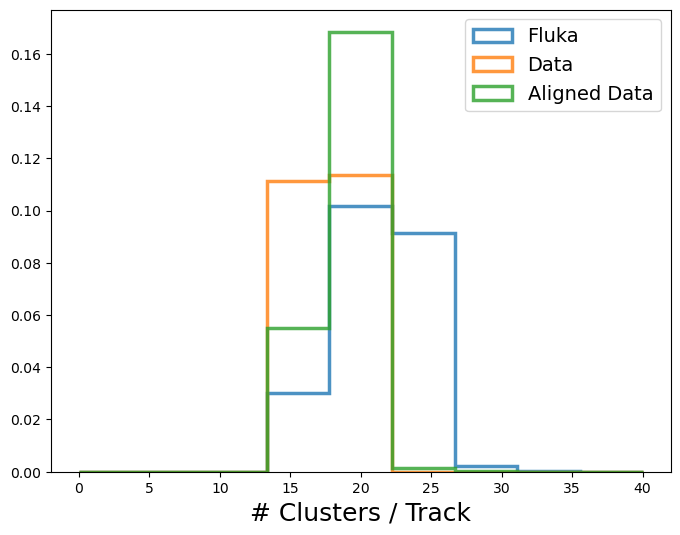

In [14]:
plt.figure(figsize=(8, 6))

track_cutf = ak.where(ak.num(fluka['fitParam_x'])==1)
track_cutc = ak.where(ak.num(collision['fitParam_x'])==1)
track_cutac = ak.where(ak.num(ali_collision['fitParam_x'])==1)

fluka_new = fluka[track_cutf]
collision_new = collision[track_cutf]
ali_collision_new = ali_collision[track_cutf]

evt_cutf = ak.where((ak.min(ak.flatten(fluka_new['fitParam_align_stationId_sp']), axis=-1)==0)&(ak.flatten(fluka_new['fitParam_chi2'])<300)&(ak.flatten(fluka_new['fitParam_nMeasurements'])>15))
evt_cutc = ak.where((ak.min(ak.flatten(collision_new['fitParam_align_stationId_sp']), axis=-1)==0)&(ak.flatten(collision_new['fitParam_chi2'])<300)&(ak.flatten(collision_new['fitParam_nMeasurements'])>15))
evt_cutac = ak.where((ak.min(ak.flatten(ali_collision_new['fitParam_align_stationId_sp']), axis=-1)==0)&(ak.flatten(ali_collision_new['fitParam_chi2'])<300)&(ak.flatten(ali_collision_new['fitParam_nMeasurements'])>15))


plt.hist(ak.flatten(fluka_new['fitParam_nMeasurements'])[evt_cutf], histtype='step', linewidth=2.5, bins=np.linspace(0, 40, 10), alpha=0.8, density=True, label='Fluka')
# plt.hist(ak.flatten(fluka['fitParam_nStates']), histtype='step', linewidth=2.5, bins=np.linspace(0, 100, 50), alpha=0.8, density=True, label='Fluka not')
plt.hist(ak.flatten(collision_new['fitParam_nMeasurements'])[evt_cutc], histtype='step', linewidth=2.5, bins=np.linspace(0, 40, 10), alpha=0.8, density=True, label='Data')
# plt.hist(ak.flatten(collision['fitParam_nStates']), histtype='step', linewidth=2.5, bins=np.linspace(0, 100, 50), alpha=0.8, density=True, label='Data not')
plt.hist(ak.flatten(ali_collision_new['fitParam_nMeasurements'])[evt_cutac], histtype='step', linewidth=2.5, bins=np.linspace(0, 40, 10), alpha=0.8, density=True, label='Aligned Data')
plt.xlabel('# Clusters / Track', fontsize=18)
# plt.ylabel('Events', fontsize=18)
plt.legend(fontsize=14)
# plt.title('Chi2', fontsize=22)
# plt.savefig('chi2.png')
plt.show()

In [13]:
data=collision
print(len(data))
cut1 = ak.where(ak.num(data['fitParam_x'])==1)
fluka_new = data[cut1]
print(len(fluka_new))
cut2 = ak.where((ak.min(ak.flatten(fluka_new['fitParam_align_stationId_sp']), axis=-1)==0))
fluka_new = fluka_new[cut2]
print(len(fluka_new))
cut3 = ak.where((ak.flatten(fluka_new['fitParam_nMeasurements'])>15))
fluka_new = fluka_new[cut3]
print(len(fluka_new))
cut4 = ak.where((ak.flatten(fluka_new['fitParam_chi2'])<300))
fluka_new = fluka_new[cut4]
print(len(fluka_new))

100000
85742
65240
39621
1684


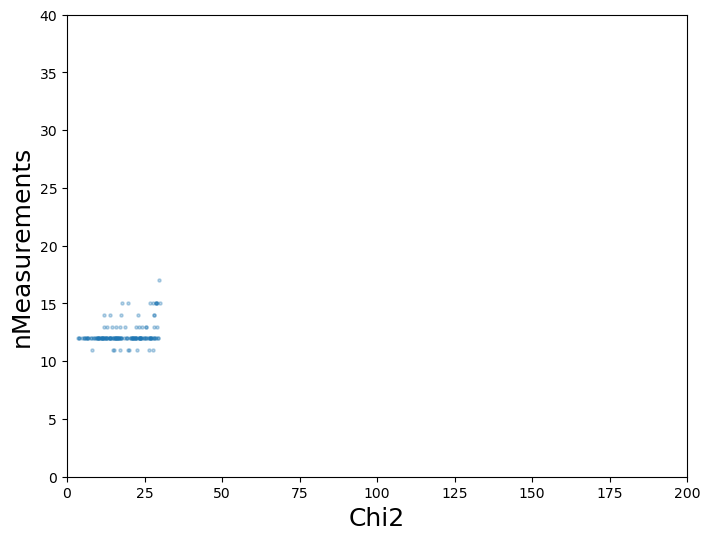

In [110]:
plt.figure(figsize=(8, 6), dpi=100)

plt.scatter(ak.flatten(fluka_new['fitParam_chi2']), ak.flatten(fluka_new['fitParam_nMeasurements']), alpha=0.3, s=5, label='postive')

# plt.legend(fontsize=14)
plt.xlabel('Chi2', fontsize=18)
plt.ylabel('nMeasurements', fontsize=18)
#plt.yscale('log')
plt.xlim(0, 200)
plt.ylim(0, 40)

plt.show()

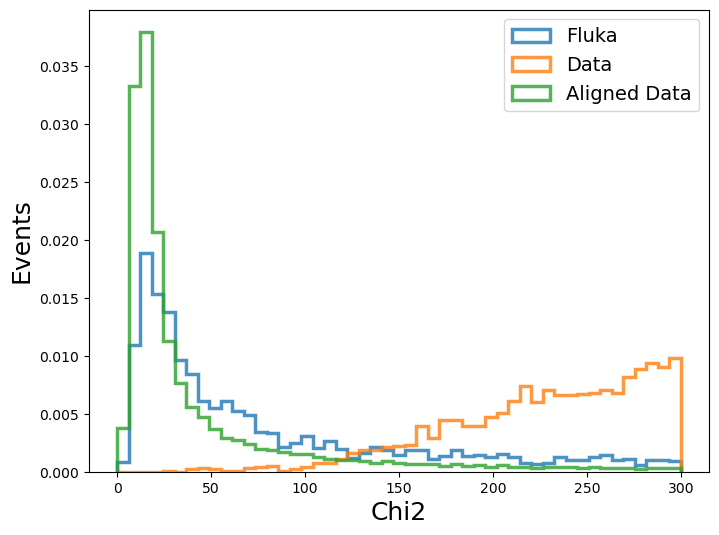

In [17]:
plt.figure(figsize=(8, 6))


track_cutf = ak.where(ak.num(fluka['fitParam_x'])==1)
track_cutc = ak.where(ak.num(collision['fitParam_x'])==1)
track_cutac = ak.where(ak.num(ali_collision['fitParam_x'])==1)

fluka_new = fluka[track_cutf]
collision_new = collision[track_cutc]
ali_collision_new = ali_collision[track_cutac]

evt_cutf = ak.where((ak.min(ak.flatten(fluka_new['fitParam_align_stationId_sp']), axis=-1)==0)&(ak.flatten(fluka_new['fitParam_chi2'])<300)&(ak.flatten(fluka_new['fitParam_nMeasurements'])>15))
evt_cutc = ak.where((ak.min(ak.flatten(collision_new['fitParam_align_stationId_sp']), axis=-1)==0)&(ak.flatten(collision_new['fitParam_nMeasurements'])>15)&(ak.flatten(collision_new['fitParam_chi2'])<300))
evt_cutac = ak.where((ak.min(ak.flatten(ali_collision_new['fitParam_align_stationId_sp']), axis=-1)==0)&(ak.flatten(ali_collision_new['fitParam_chi2'])<300)&(ak.flatten(ali_collision_new['fitParam_nMeasurements'])>15))

plt.hist(ak.flatten(fluka_new['fitParam_chi2'])[evt_cutf], histtype='step', linewidth=2.5, bins=np.linspace(0, 300, 50), alpha=0.8, density=True, label='Fluka')
plt.hist(ak.flatten(collision_new['fitParam_chi2'])[evt_cutc], histtype='step', linewidth=2.5, bins=np.linspace(0, 300, 50), alpha=0.8, density=True, label='Data')
plt.hist(ak.flatten(ali_collision_new['fitParam_chi2'])[evt_cutac], histtype='step', linewidth=2.5, bins=np.linspace(0, 300, 50), alpha=0.8, density=True, label='Aligned Data')
plt.xlabel('Chi2', fontsize=18)
plt.ylabel('Events', fontsize=18)
plt.legend(fontsize=14)
# plt.title('Chi2', fontsize=22)
# plt.savefig('chi2.png')
plt.show()

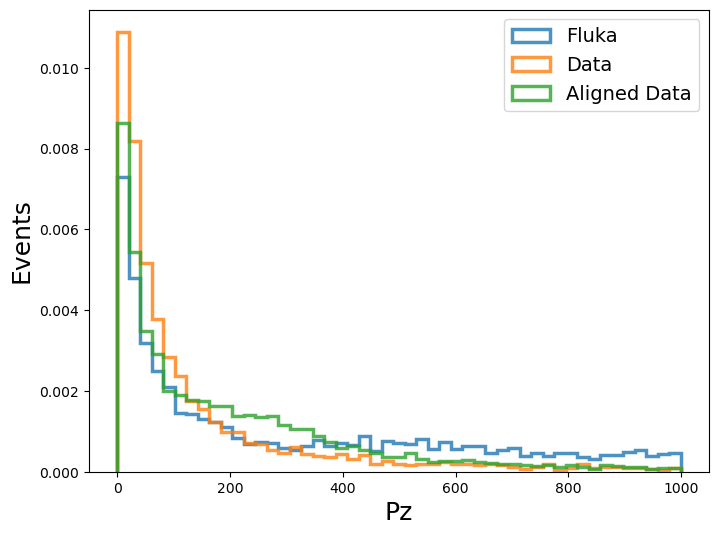

In [30]:
plt.figure(figsize=(8, 6))
plt.hist(ak.flatten(fluka['fitParam_pz'][ak.where(ak.num(fluka['fitParam_x'])==1)]), histtype='step', linewidth=2.5, bins=np.linspace(0, 1000, 50), alpha=0.8, density=True, label='Fluka')
plt.hist(ak.flatten(collision['fitParam_pz'][ak.where(ak.num(collision['fitParam_x'])==1)]), histtype='step', linewidth=2.5, bins=np.linspace(0, 1000, 50), alpha=0.8, density=True, label='Data')
plt.hist(ak.flatten(ali_collision['fitParam_pz'][ak.where(ak.num(ali_collision['fitParam_x'])==1)]), histtype='step', linewidth=2.5, bins=np.linspace(0, 1000, 50), alpha=0.8, density=True, label='Aligned Data')
plt.xlabel('Pz', fontsize=18)
plt.ylabel('Events', fontsize=18)
plt.legend(fontsize=14)
# plt.title('Chi2', fontsize=22)
# plt.savefig('chi2.png')
plt.show()

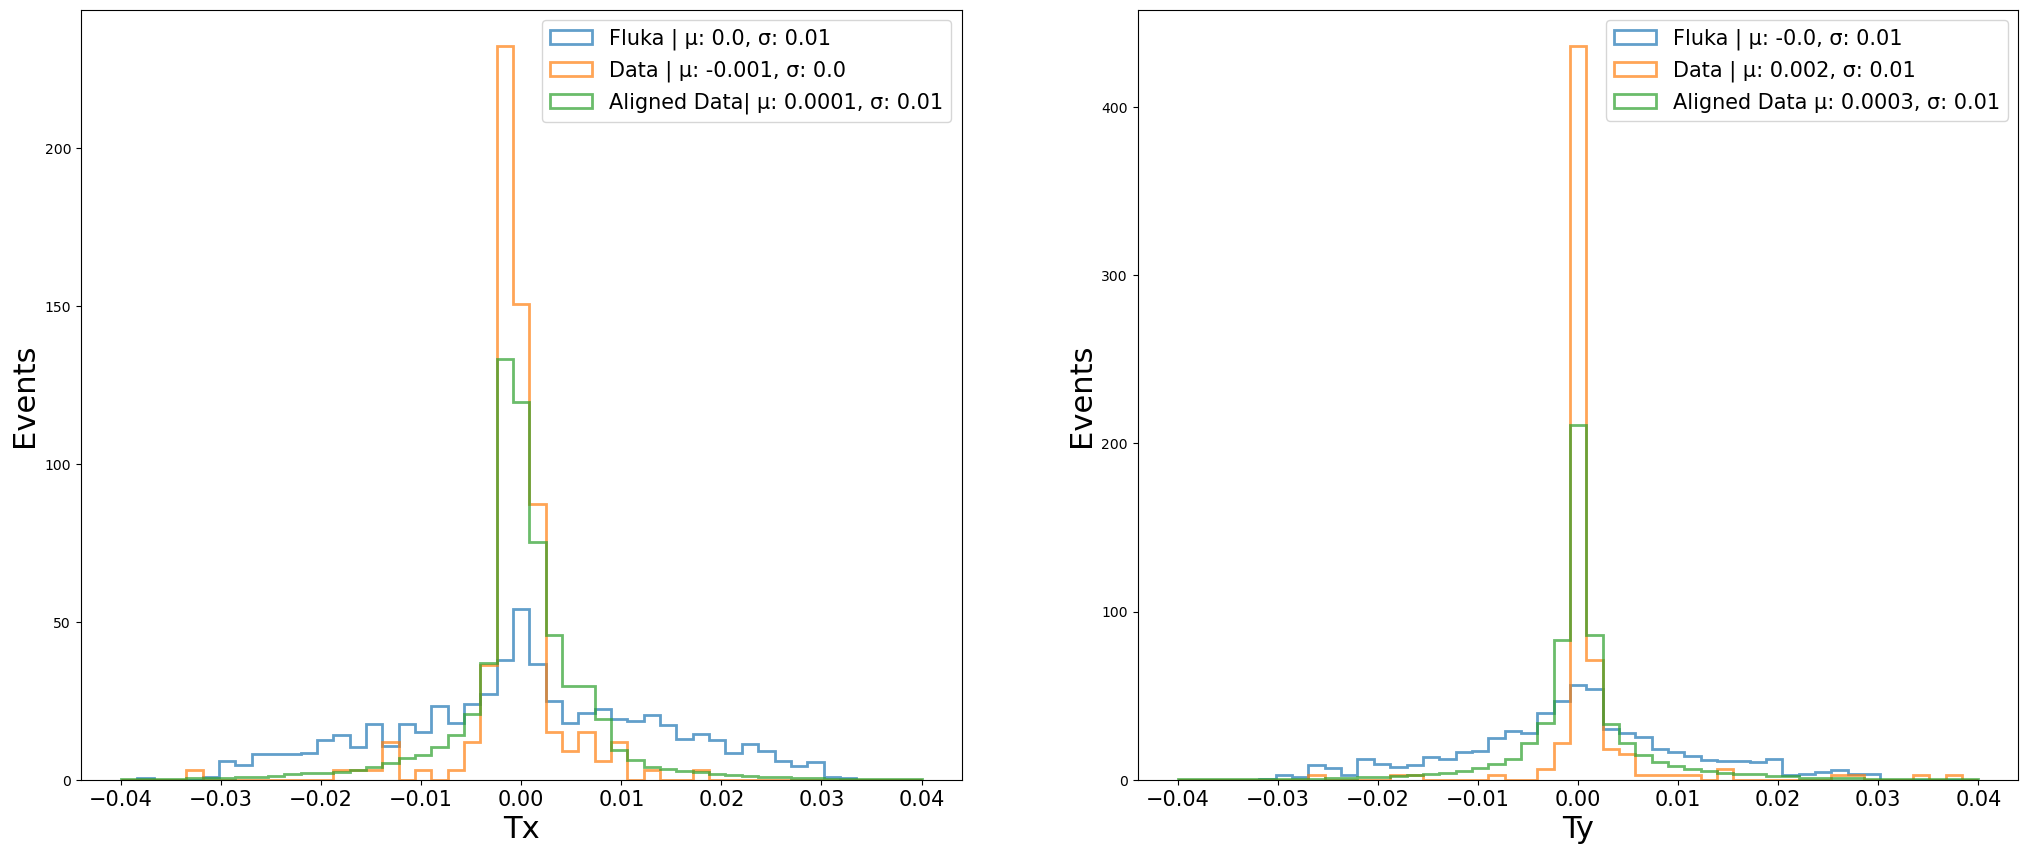

In [136]:
# tx
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
bin = np.linspace(-0.04, 0.04, 50)
fluka_tx, coll_tx, ali_coll_tx = ak.flatten(fluka_new['fitParam_px'])[evt_cutf]/ak.flatten(fluka_new['fitParam_pz'])[evt_cutf], ak.flatten(collision_new['fitParam_px'])[evt_cutc]/ak.flatten(collision_new['fitParam_pz'])[evt_cutc], ak.flatten(ali_collision_new['fitParam_px'])[evt_cutac]/ak.flatten(ali_collision_new['fitParam_pz'])[evt_cutac]
plt.hist(fluka_tx, histtype='step', linewidth=2, bins=bin, alpha=0.7, density=True, label=f'Fluka | µ: {round(np.mean(fluka_tx), 3)}, σ: {round(np.std(fluka_tx), 2)}')
plt.hist(coll_tx, histtype='step', linewidth=2, bins=bin, alpha=0.7, density=True, label=f'Data | µ: {round(np.mean(coll_tx), 3)}, σ: {round(np.std(coll_tx), 2)}')
plt.hist(ali_coll_tx, histtype='step', linewidth=2, bins=bin, alpha=0.7, density=True, label=f'Aligned Data| µ: {round(np.mean(ali_coll_tx), 4)}, σ: {round(np.std(ali_coll_tx), 2)}')

plt.xlabel('Tx', fontsize=22)
plt.ylabel('Events', fontsize=22)
# plt.title('Tx', fontsize=22)
plt.xticks(fontsize=15)
plt.legend(fontsize=15)

# ty
plt.subplot(1, 2, 2)
fluka_ty, coll_ty, ali_coll_ty = ak.flatten(fluka_new['fitParam_py'])[evt_cutf]/ak.flatten(fluka_new['fitParam_pz'])[evt_cutf], ak.flatten(collision_new['fitParam_py'])[evt_cutc]/ak.flatten(collision_new['fitParam_pz'])[evt_cutc], ak.flatten(ali_collision_new['fitParam_py'])[evt_cutac]/ak.flatten(ali_collision_new['fitParam_pz'])[evt_cutac]
plt.hist(fluka_ty, histtype='step', linewidth=2, bins=bin, alpha=0.7, density=True, label=f'Fluka | µ: {round(np.mean(fluka_ty), 3)}, σ: {round(np.std(fluka_ty), 2)}')
plt.hist(coll_ty, histtype='step', linewidth=2, bins=bin, alpha=0.7, density=True, label=f'Data | µ: {round(np.mean(coll_ty), 3)}, σ: {round(np.std(coll_ty), 2)}')
plt.hist(ali_coll_ty, histtype='step', linewidth=2, bins=bin, alpha=0.7, density=True, label=f'Aligned Data µ: {round(np.mean(ali_coll_ty), 4)}, σ: {round(np.std(ali_coll_ty), 2)}')

plt.xlabel('Ty', fontsize=22)
plt.ylabel('Events', fontsize=22)
# plt.title('ty', fontsize=22)
plt.xticks(fontsize=15)

plt.legend(fontsize=15)
# plt.savefig('tx_ty.png')
plt.show()


In [28]:
def momentum(data, charge):
    p = np.sqrt(ak.flatten(data['fitParam_px'])**2 + ak.flatten(data['fitParam_py'])**2 + ak.flatten(data['fitParam_pz'])**2)
    loc = ak.where(ak.flatten(data['fitParam_charge']) == charge)
    if charge==-1 or charge==1:
        return p[loc]
    else:
        return p

In [137]:
def momentum(data, charge):
    
    track_cutf = ak.where(ak.num(data['fitParam_x'])==1)
    data_new = data[track_cutf]
    evt_cutf = ak.where((ak.flatten(data_new['fitParam_charge']) == charge)&
                        (ak.min(ak.flatten(data_new['fitParam_align_stationId_sp']), axis=-1)==0)&
                        (ak.flatten(data_new['fitParam_chi2'])<40)&
                        (ak.flatten(data_new['fitParam_nMeasurements'])>10))
    
    p = np.sqrt(ak.flatten(data['fitParam_px'])**2 + ak.flatten(data['fitParam_py'])**2 + ak.flatten(data['fitParam_pz'])**2)
    tx = ak.flatten(data['fitParam_px'])/ak.flatten(data['fitParam_pz'])
    ty = ak.flatten(data['fitParam_py'])/ak.flatten(data['fitParam_pz'])

    # loc = ak.where(ak.flatten(data['fitParam_charge']) == charge)
    res_x = ak.flatten(data['fitParam_align_local_residual_x_sp'])
    
    if charge==-1 or charge==1:
        return p[evt_cutf], res_x[evt_cutf], tx[evt_cutf], ty[evt_cutf]
    else:
        return p, res_x, tx, ty

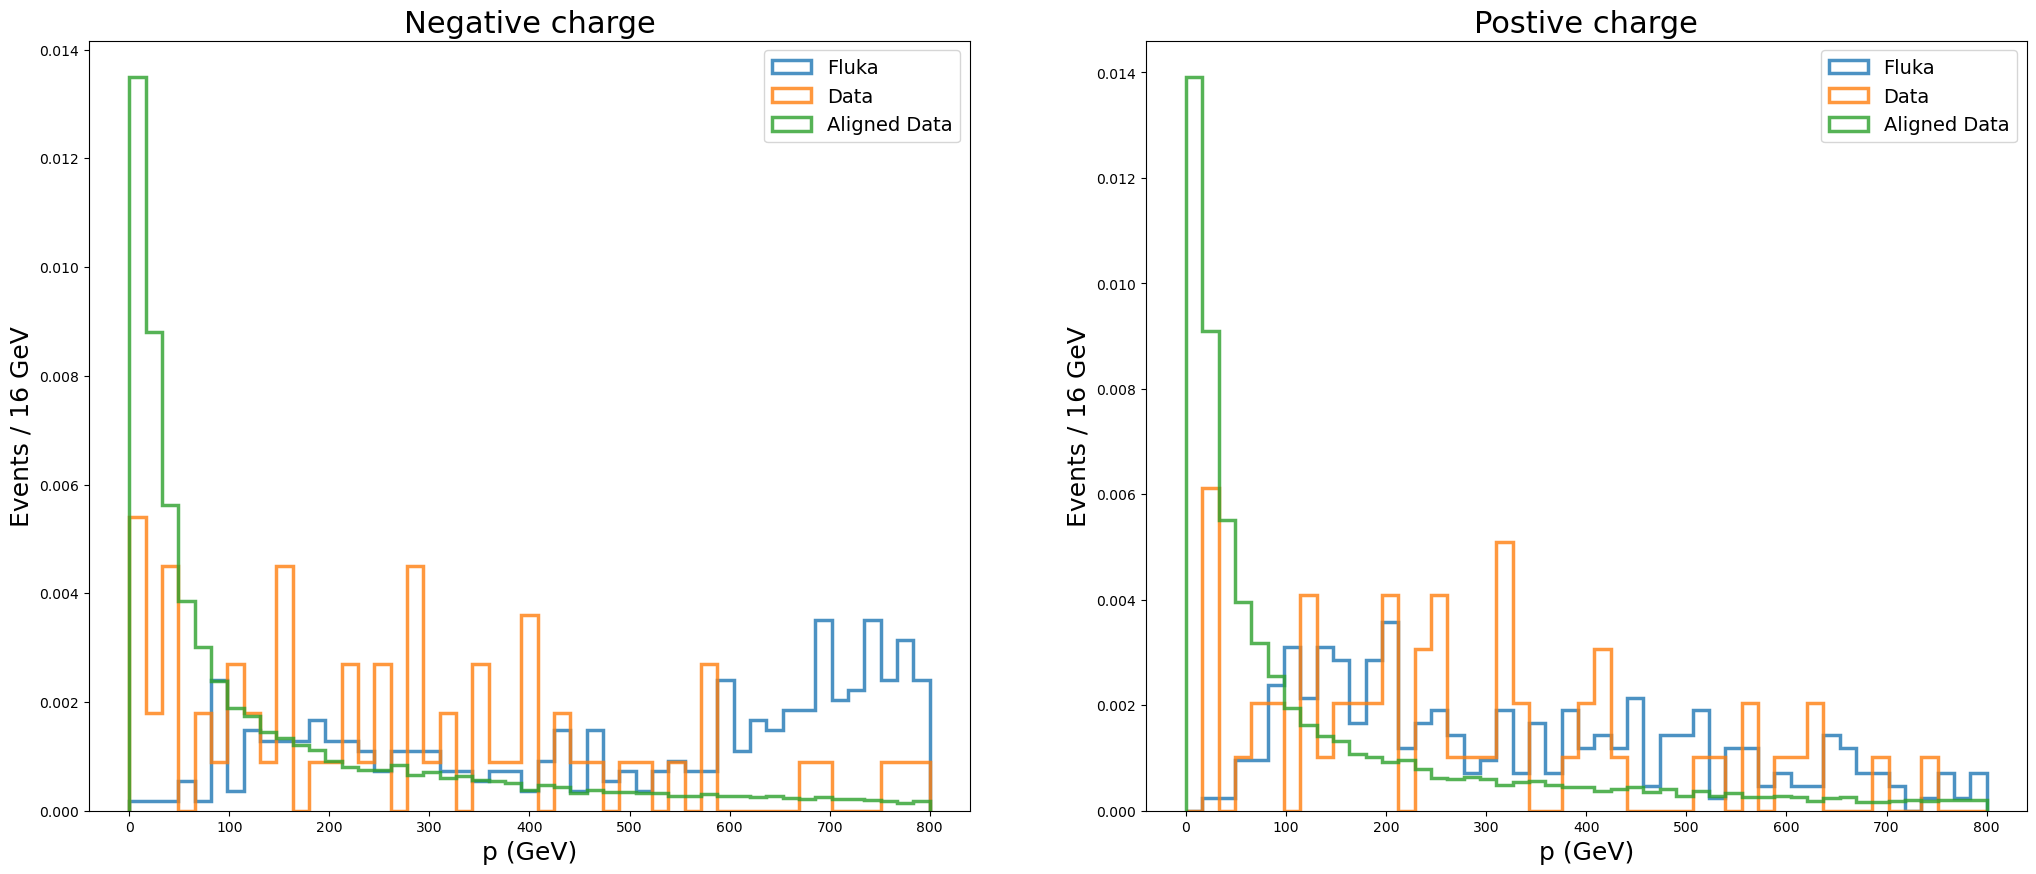

In [138]:
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
momn, resn, txn, tyn = momentum(collision, 1)
amomn, aresn, atxn, atyn = momentum(ali_collision, 1)
fmomn, fresn, ftxn, ftyn = momentum(fluka, 1)
plt.hist(fmomn, histtype='step', linewidth=2.5, density="true", bins=np.linspace(0, 800, 50), alpha=0.8, label='Fluka')
plt.hist(momn,  histtype='step', linewidth=2.5, density="true", bins=np.linspace(0, 800, 50), alpha=0.8, label='Data')
plt.hist(amomn,  histtype='step', linewidth=2.5, density="true", bins=np.linspace(0, 800, 50), alpha=0.8, label='Aligned Data')
plt.xlabel('p (GeV)', fontsize=18)
plt.ylabel('Events / 16 GeV', fontsize=18)
plt.legend(fontsize=14)
plt.title('Negative charge', fontsize=22)

plt.subplot(1, 2, 2)
mom, res, tx, ty = momentum(collision, -1)
amom, ares, atx, aty = momentum(ali_collision, -1)
fmom, fres, ftx, fty = momentum(fluka, -1)
plt.hist(fmom, histtype='step', linewidth=2.5,density="true", bins=np.linspace(0, 800, 50), alpha=0.8, label='Fluka')
plt.hist(mom,  histtype='step', linewidth=2.5, density="true", bins=np.linspace(0, 800, 50), alpha=0.8, label='Data')
plt.hist(amom,  histtype='step', linewidth=2.5, density="true", bins=np.linspace(0, 800, 50), alpha=0.8, label='Aligned Data')
plt.xlabel('p (GeV)', fontsize=18)
plt.ylabel('Events / 16 GeV', fontsize=18)
plt.legend(fontsize=14)
plt.title('Postive charge', fontsize=22)
plt.show()

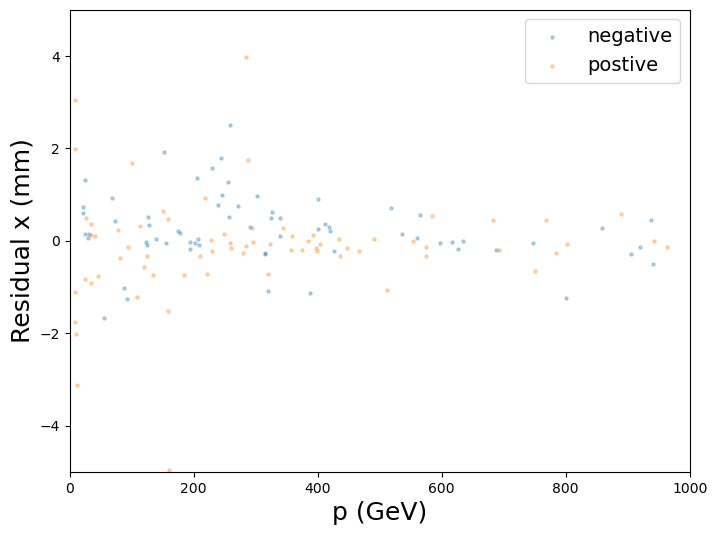

In [164]:
plt.figure(figsize=(8, 6), dpi=100)
momp, resp, tx, ty = momentum(collision, 1)
momn, resn, txn, tyn = momentum(collision, -1)

# plt.scatter(mom, ak.mean(ak.flatten(fluka['fitParam_align_local_residual_x_sp']), axis=1), s=5)
# plt.scatter(momp, np.median(resp, axis=1), alpha=0.3, s=5)
plt.scatter(momn, ak.mean(resn, axis=1), alpha=0.3, s=5, label='negative')
plt.scatter(momp, ak.mean(resp, axis=1), alpha=0.3, s=5, label='postive')

plt.legend(fontsize=14)
plt.xlabel('p (GeV)', fontsize=18)
plt.ylabel('Residual x (mm)', fontsize=18)
#plt.yscale('log')
plt.ylim(-5, 5)
plt.xlim(0, 1000)

plt.show()

In [115]:
def res(data, station, layer):
    
    # pz = ak.flatten(data['fitParam_pz'])
    # chi2 = ak.flatten(data['fitParam_chi2'])
    
    # cuts = ak.where((chi2<100)|(pz>300)&(ak.num(ak.flatten(data['fitParam_align_local_residual_x_sp']))>15))
    #cuts = ak.where((ak.num(ak.flatten(data['fitParam_align_local_residual_x_sp']))>15))
    
    track_cutf = ak.where(ak.num(data['fitParam_x'])==1)
    fluka_new = data[track_cutf]
    cut1 = ak.where((ak.flatten(fluka_new['fitParam_chi2'])<100) |
                    (ak.flatten(fluka_new['fitParam_pz'])>300))
    cut2 = ak.where((ak.min(ak.flatten(fluka_new['fitParam_align_stationId_sp'])[cut1], axis=-1)==0)&
                    (ak.flatten(fluka_new['fitParam_nMeasurements'])[cut1]>14))
    # cuts = ak.where((ak.min(ak.flatten(fluka_new['fitParam_align_stationId_sp']), axis=-1)==0)&
    #                     (ak.flatten(fluka_new['fitParam_chi2'])<300)&
    #                     (ak.flatten(fluka_new['fitParam_nMeasurements'])>14)|
    #                     (ak.flatten(fluka_new['fitParam_pz'])>100))

    
    res_x = ak.flatten(ak.flatten(data['fitParam_align_local_residual_x_sp'])[cut2])
    sta = ak.flatten(ak.flatten(data['fitParam_align_stationId_sp'])[cut2])
    lay = ak.flatten(ak.flatten(data['fitParam_align_layerId_sp'])[cut2])
    mod = ak.flatten(ak.flatten(data['fitParam_align_moduleId_sp'])[cut2])
    ste = ak.flatten(ak.flatten(data['fitParam_align_stereoId'])[cut2])
    bias = ak.flatten(ak.flatten(data['fitParam_align_unbiased_sp'])[cut2])

    
    
    return res_x[ak.where((sta==station)&(lay==layer)&(bias==2))]

In [145]:
def res(data, station):
    
    # pz = ak.flatten(data['fitParam_pz'])
    # chi2 = ak.flatten(data['fitParam_chi2'])
    
    # cuts = ak.where((chi2<100)|(pz>300)&(ak.num(ak.flatten(data['fitParam_align_local_residual_x_sp']))>15))
    #cuts = ak.where((ak.num(ak.flatten(data['fitParam_align_local_residual_x_sp']))>15))
    
    track_cutf = ak.where(ak.num(data['fitParam_x'])==1)
    fluka_new = data[track_cutf]
    cut1 = ak.where((ak.flatten(fluka_new['fitParam_chi2'])<100) |
                    (ak.flatten(fluka_new['fitParam_pz'])>300))
    cut2 = ak.where((ak.min(ak.flatten(fluka_new['fitParam_align_stationId_sp'])[cut1], axis=-1)==0)&
                    (ak.flatten(fluka_new['fitParam_nMeasurements'])[cut1]>14))
    # cuts = ak.where((ak.min(ak.flatten(fluka_new['fitParam_align_stationId_sp']), axis=-1)==0)&
    #                     (ak.flatten(fluka_new['fitParam_chi2'])<300)&
    #                     (ak.flatten(fluka_new['fitParam_nMeasurements'])>14)|
    #                     (ak.flatten(fluka_new['fitParam_pz'])>100))

    
    res_x = ak.flatten(ak.flatten(data['fitParam_align_local_residual_x_sp'])[cut2])
    sta = ak.flatten(ak.flatten(data['fitParam_align_stationId_sp'])[cut2])
    lay = ak.flatten(ak.flatten(data['fitParam_align_layerId_sp'])[cut2])
    mod = ak.flatten(ak.flatten(data['fitParam_align_moduleId_sp'])[cut2])
    ste = ak.flatten(ak.flatten(data['fitParam_align_stereoId'])[cut2])
    bias = ak.flatten(ak.flatten(data['fitParam_align_unbiased_sp'])[cut2])

    
    
    return res_x[ak.where((sta==station)&(bias==2))]

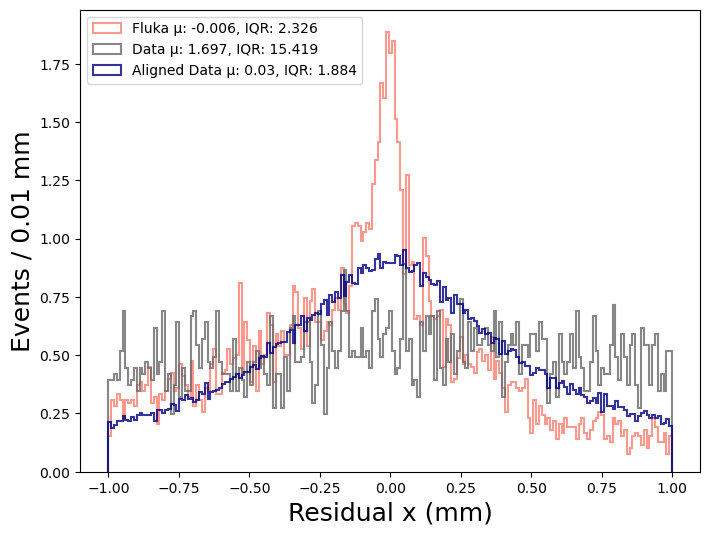

In [147]:



        plt.figure(figsize=(8, 6),  dpi=100)

        plt.hist(res(fluka, 0), color="salmon", histtype='step', linewidth=1.5, bins=np.linspace(-1, 1, 200), density=True, alpha=0.8, label=f'Fluka µ: {round(np.median(res(fluka, 0)), 3)}, IQR: {round(iqr(res(fluka, 0)), 3)}')
        plt.hist(res(collision, 0),color="dimgray", histtype='step', linewidth=1.5, bins=np.linspace(-1, 1, 200), density=True,  alpha=0.8, label=f'Data µ: {round(np.median(res(collision, 0)), 3)}, IQR: {round(iqr(res(collision, 0)), 3)}')
        plt.hist(res(ali_collision, 0), color="navy", histtype='step',linewidth=1.5, bins=np.linspace(-1, 1, 200), density=True,  alpha=0.8, label=f'Aligned Data µ: {round(np.median(res(ali_collision, 0)), 3)}, IQR: {round(iqr(res(ali_collision, 0)), 3)}')
        plt.xlabel('Residual x (mm)', fontsize=18)
        plt.ylabel('Events / 0.01 mm', fontsize=18)
        #plt.xlim(-0.2, 0.2)
        # plt.margins(0.0000001)
        plt.legend(fontsize=10, loc='upper left')
        # plt.title(f'(station={i}, layer={j})', fontsize=18)
        # plt.savefig('SIC_vs_TPR.pdf', dpi=1200, format='pdf', bbox_inches='tight')
        plt.show()

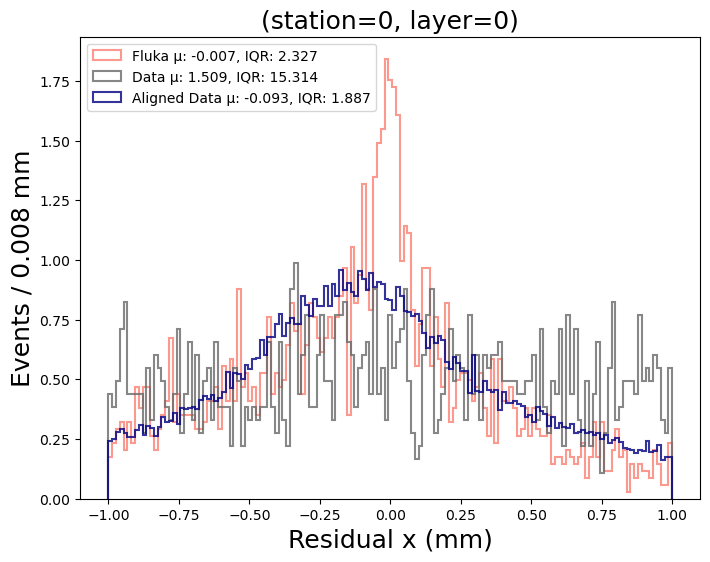

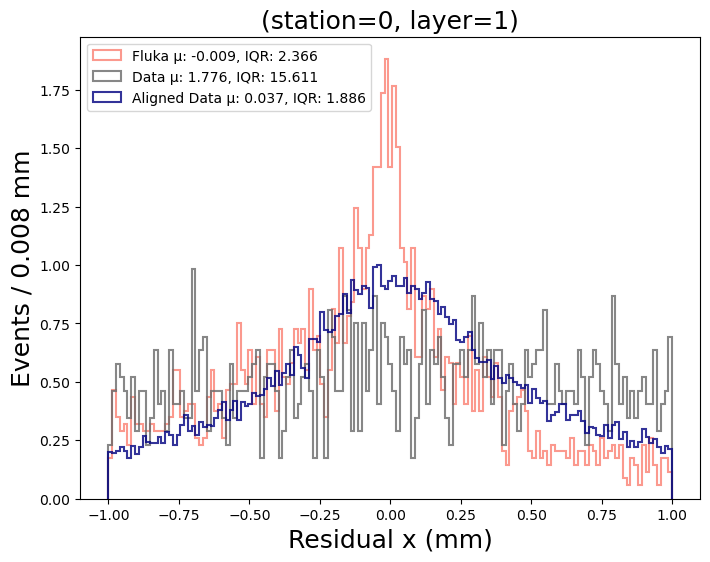

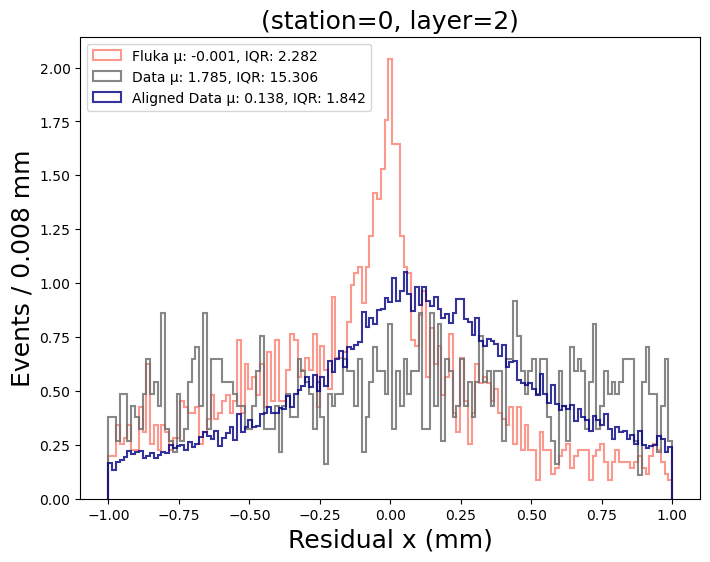

In [117]:
fluka_med = []
fluka_iqr= []
col_med = []
col_iqr= []
acol_med = []
acol_iqr= []
idx_list = []
for i in range(1):
    for j in range(3):
        plt.figure(figsize=(8, 6),  dpi=100)
        idx_list.append(str(i)+str(j))
        fluka_med.append(np.median(res(fluka, i, j)))
        fluka_iqr.append(iqr(res(fluka, i, j)))
        # fluka_iqr[str(i)+str(j)] = np.quantile(res(fluka, i, j), 0.16), np.quantile(res(fluka, i, j), 0.84)
        col_med.append(np.median(res(collision, i, j)))
        col_iqr.append(iqr(res(collision, i, j)))
        acol_med.append(np.median(res(ali_collision, i, j)))
        acol_iqr.append(iqr(res(ali_collision, i, j)))
        # col_iqr[str(i)+str(j)]=np.quantile(res(collision, i, j), 0.16), np.quantile(res(collision, i, j), 0.84)
        plt.hist(res(fluka, i, j), color="salmon", histtype='step', linewidth=1.5, bins=np.linspace(-1, 1, 150), density=True, alpha=0.8, label=f'Fluka µ: {round(np.median(res(fluka, i, j)), 3)}, IQR: {round(iqr(res(fluka, i, j)), 3)}')
        plt.hist(res(collision, i, j),color="dimgray", histtype='step', linewidth=1.5, bins=np.linspace(-1, 1, 150), density=True,  alpha=0.8, label=f'Data µ: {round(np.median(res(collision, i, j)), 3)}, IQR: {round(iqr(res(collision, i, j)), 3)}')
        plt.hist(res(ali_collision, i, j), color="navy", histtype='step',linewidth=1.5, bins=np.linspace(-1, 1, 150), density=True,  alpha=0.8, label=f'Aligned Data µ: {round(np.median(res(ali_collision, i, j)), 3)}, IQR: {round(iqr(res(ali_collision, i, j)), 3)}')
        plt.xlabel('Residual x (mm)', fontsize=18)
        plt.ylabel('Events / 0.008 mm', fontsize=18)
        #plt.xlim(-0.2, 0.2)
        # plt.margins(0.0000001)
        plt.legend(fontsize=10, loc='upper left')
        plt.title(f'(station={i}, layer={j})', fontsize=18)
        # plt.savefig('SIC_vs_TPR.pdf', dpi=1200, format='pdf', bbox_inches='tight')
        plt.show()

In [119]:
def res(data, station, layer):
    
    # pz = ak.flatten(data['fitParam_pz'])
    # chi2 = ak.flatten(data['fitParam_chi2'])
    
    # cuts = ak.where((chi2<100)|(pz>300)&(ak.num(ak.flatten(data['fitParam_align_local_residual_x_sp']))>15))
    #cuts = ak.where((ak.num(ak.flatten(data['fitParam_align_local_residual_x_sp']))>15))
    
    track_cutf = ak.where(ak.num(data['fitParam_x'])==1)
    fluka_new = data[track_cutf]
    cut1 = ak.where((ak.flatten(fluka_new['fitParam_chi2'])<100) |
                    (ak.flatten(fluka_new['fitParam_pz'])>300))
    cut2 = ak.where((ak.min(ak.flatten(fluka_new['fitParam_align_stationId_sp'])[cut1], axis=-1)==0)&
                    (ak.flatten(fluka_new['fitParam_nMeasurements'])[cut1]>14))
    # cuts = ak.where((ak.min(ak.flatten(fluka_new['fitParam_align_stationId_sp']), axis=-1)==0)&
    #                     (ak.flatten(fluka_new['fitParam_chi2'])<300)&
    #                     (ak.flatten(fluka_new['fitParam_nMeasurements'])>14)|
    #                     (ak.flatten(fluka_new['fitParam_pz'])>100))

    
    res_x = ak.flatten(ak.flatten(data['fitParam_align_local_residual_x_sp'])[cut2])
    sta = ak.flatten(ak.flatten(data['fitParam_align_stationId_sp'])[cut2])
    lay = ak.flatten(ak.flatten(data['fitParam_align_layerId_sp'])[cut2])
    mod = ak.flatten(ak.flatten(data['fitParam_align_moduleId_sp'])[cut2])
    ste = ak.flatten(ak.flatten(data['fitParam_align_stereoId'])[cut2])
    bias = ak.flatten(ak.flatten(data['fitParam_align_unbiased_sp'])[cut2])

    
    
    return res_x[ak.where((sta==station)&(lay==layer))]

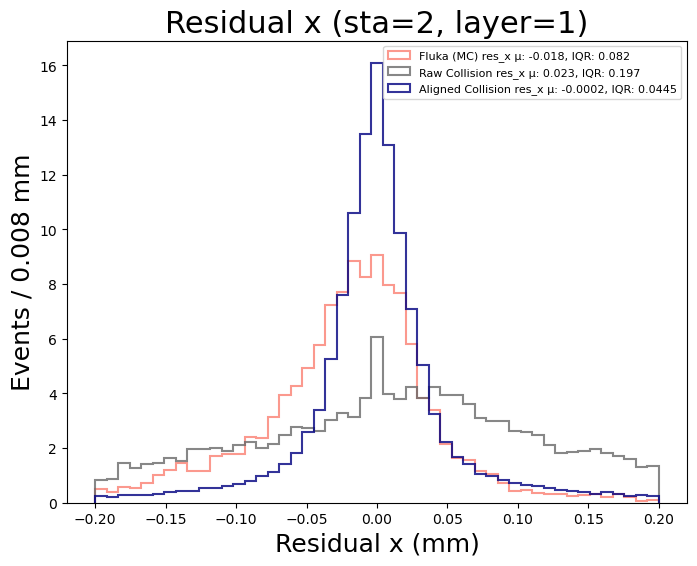

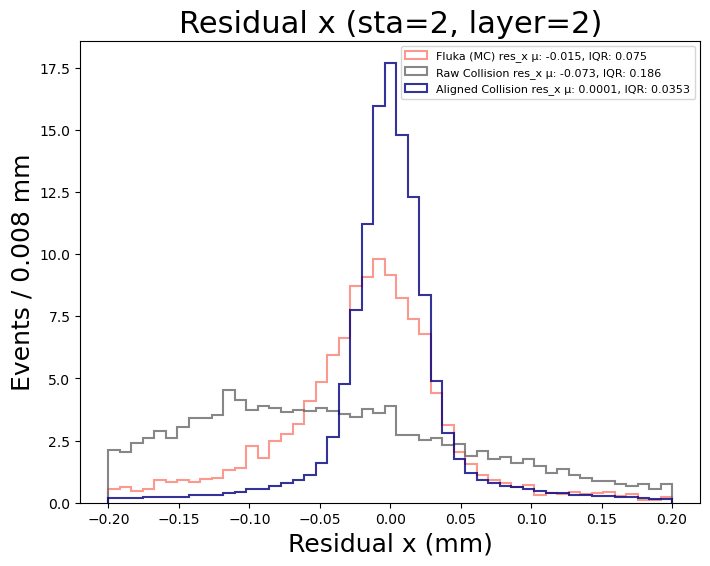

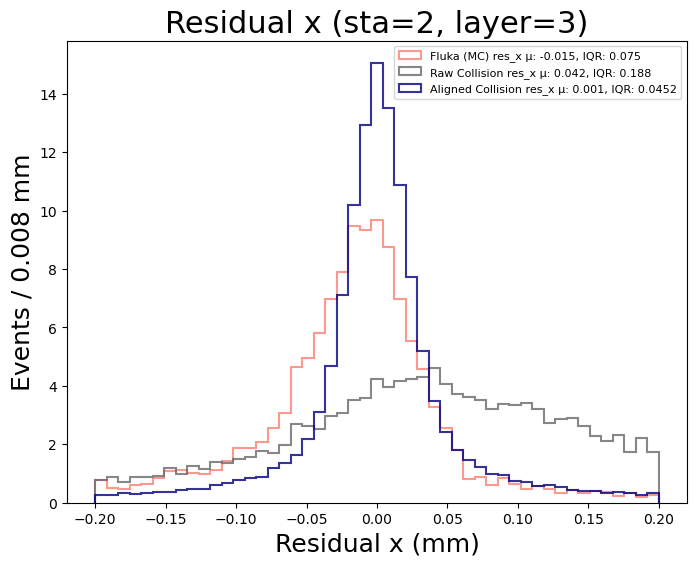

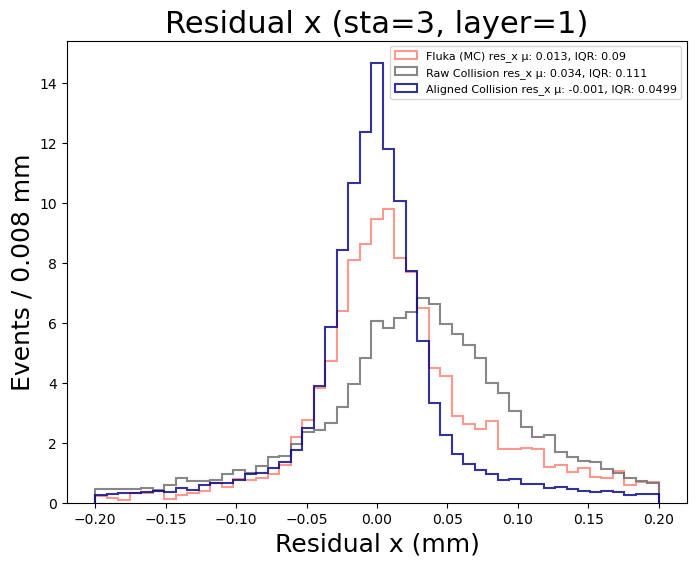

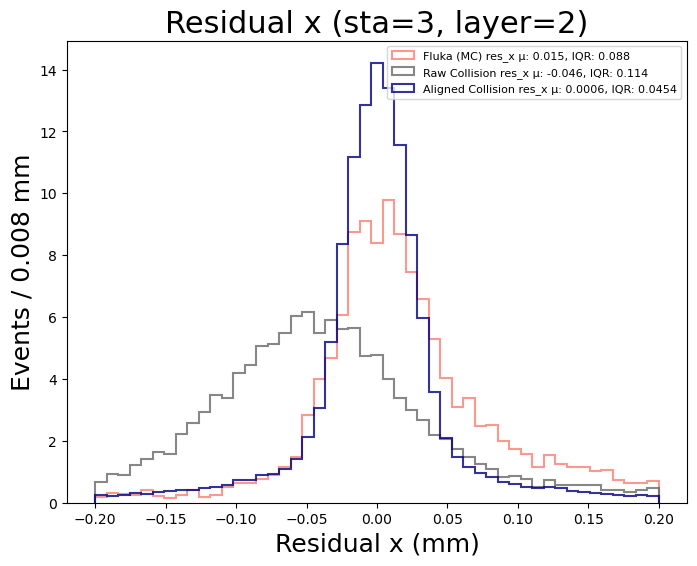

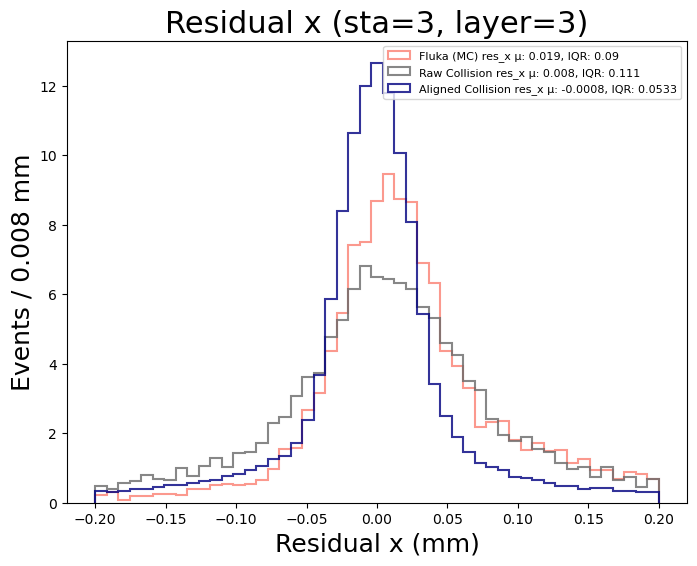

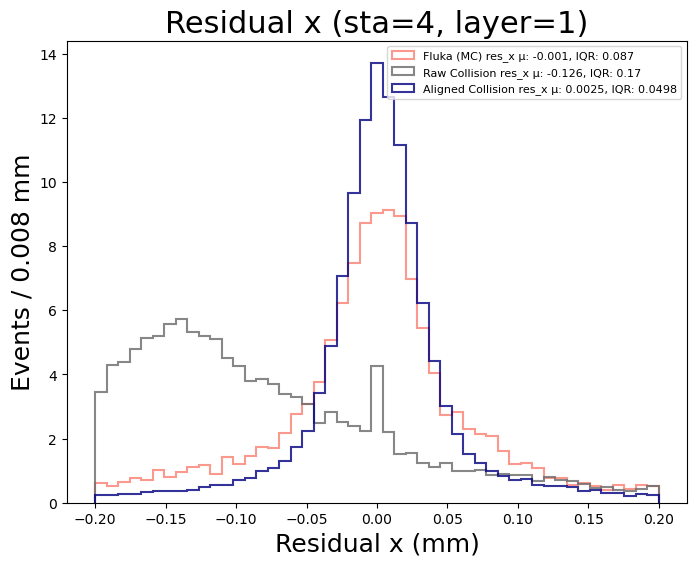

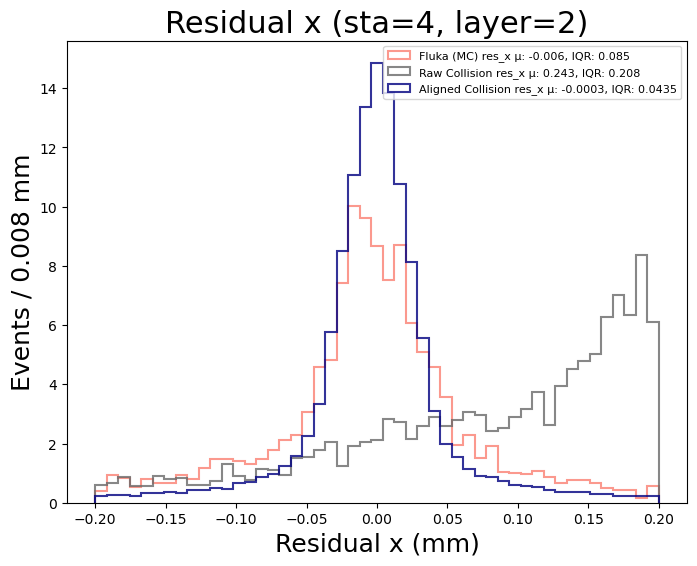

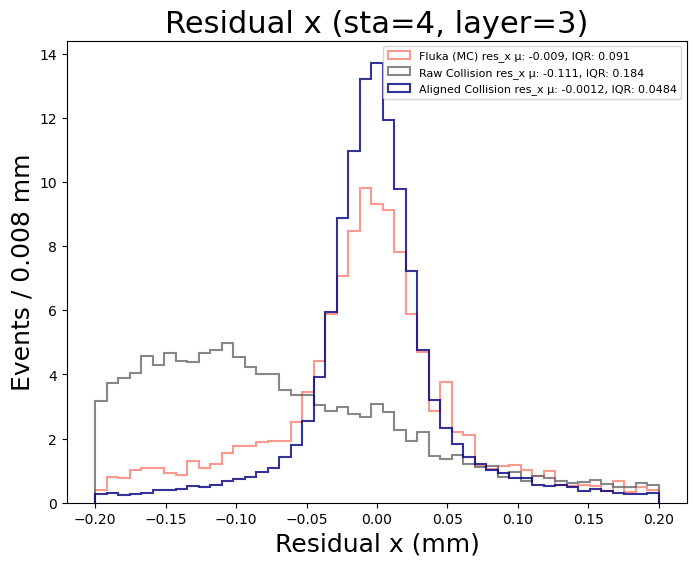

In [121]:
for i in range(1,4):
    for j in range(3):
        idx_list.append(str(i)+str(j))
        fluka_med.append(np.median(res(fluka, i, j)))
        fluka_iqr.append(iqr(res(fluka, i, j)))
        # fluka_iqr[str(i)+str(j)] = np.quantile(res(fluka, i, j), 0.16), np.quantile(res(fluka, i, j), 0.84)
        col_med.append(np.median(res(collision, i, j)))
        col_iqr.append(iqr(res(collision, i, j)))
        # col_iqr[str(i)+str(j)] = np.quantile(res(collision, i, j), 0.16), np.quantile(res(collision, i, j), 0.84)
        acol_med.append(np.median(res(ali_collision, i, j)))
        acol_iqr.append(iqr(res(ali_collision, i, j)))
        
        plt.figure(figsize=(8, 6))
        plt.hist(res(fluka, i, j), histtype='step', color="salmon", linewidth=1.5, bins=np.linspace(-0.2, 0.2, 50), density=True, alpha=0.8, label=f'Fluka (MC) res_x µ: {round(np.median(res(fluka, i, j)), 3)}, IQR: {round(iqr(res(fluka, i, j)), 3)}')
        plt.hist(res(collision, i, j),histtype='step', color="dimgray", linewidth=1.5, bins=np.linspace(-0.2, 0.2, 50), density=True,  alpha=0.8, label=f'Raw Collision res_x µ: {round(np.median(res(collision, i, j)), 3)}, IQR: {round(iqr(res(collision, i, j)), 3)}')
        plt.hist(res(ali_collision, i, j),color="navy", histtype='step',linewidth=1.5, bins=np.linspace(-0.2, 0.2, 50), density=True,  alpha=0.8, label=f'Aligned Collision res_x µ: {round(np.median(res(ali_collision, i, j)), 4)}, IQR: {round(iqr(res(ali_collision, i, j)), 4)}')
        plt.xlabel('Residual x (mm)', fontsize=18)
        plt.ylabel('Events / 0.008 mm', fontsize=18)
        #plt.xlim(-0.2, 0.2)
        # plt.margins(0.0000001)
        plt.legend(fontsize=8, loc='upper right')
        plt.title(f'Residual x (sta={i+1}, layer={j+1})', fontsize=22)
        plt.show()

ValueError: 'x' and 'y' must have the same size

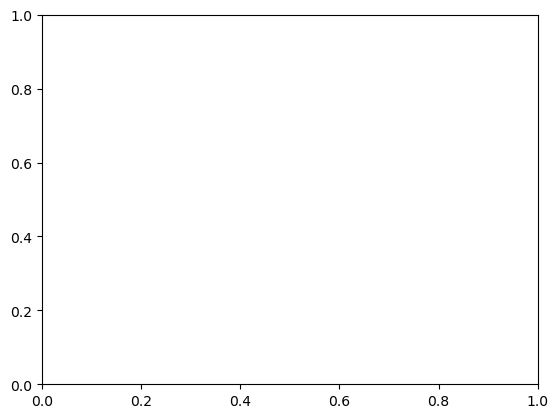

In [122]:

# x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
x=np.arange(1, 13)

# plt.scatter(x, fluka_med, marker = ".")
plt.errorbar(x, fluka_med, yerr=fluka_iqr, fmt="o", ms=8, alpha=0.8, label="Fluka")
# plt.scatter(x, col_med, marker = ".")
plt.errorbar(x+0.05, col_med, yerr=col_iqr, fmt=">", ms=8, alpha=0.6, color="black", label="Data")
plt.errorbar(x-0.05, acol_med, yerr=acol_iqr, fmt="<", ms=8, alpha=0.8, label="Aligned Data")


# plt.fill_between(x, np.array([fluka_iqr[x][0] for x in idx_list]), np.array([fluka_iqr[x][1] for x in idx_list]), color="orange", alpha=0.3)
# plt.scatter(x, fluka_med, color="orange", label="CATHODE", linestyle='-')
# plt.yscale('log')
plt.ylim(-0.2, 0.2)
plt.xlabel('Layer Number', fontsize=18)
plt.ylabel('Median Residual x', fontsize=18)
plt.legend(fontsize=8, loc='upper right')

plt.show()


In [171]:
def res(data, station, layer, stereo):
#     pz = ak.flatten(data['fitParam_pz'])
#     chi2 = ak.flatten(data['fitParam_chi2'])
#     cuts = ak.where((chi2<100)|(pz>300)&(ak.num(ak.flatten(data['fitParam_align_local_residual_x_sp']))>15))
#     evt_cut = ak.where(ak.num(data['fitParam_x'])==1)
    track_cutf = ak.where(ak.num(data['fitParam_x'])==1)
    fluka_new = data[track_cutf]
    cuts = ak.where((ak.min(ak.flatten(fluka_new['fitParam_align_stationId_sp']), axis=-1)==0)&
                        (ak.flatten(fluka_new['fitParam_chi2'])<40)&
                        (ak.flatten(fluka_new['fitParam_nMeasurements'])>10))
    
    res_x = ak.flatten(ak.flatten(data['fitParam_align_local_residual_x_sp'])[cuts])
    sta = ak.flatten(ak.flatten(data['fitParam_align_stationId_sp'])[cuts])
    lay = ak.flatten(ak.flatten(data['fitParam_align_layerId_sp'])[cuts])
    mod = ak.flatten(ak.flatten(data['fitParam_align_moduleId_sp'])[cuts])
    ste = ak.flatten(ak.flatten(data['fitParam_align_stereoId'])[cuts])
    return res_x[ak.where((sta==station)&(lay==layer)&(ste==stereo))]


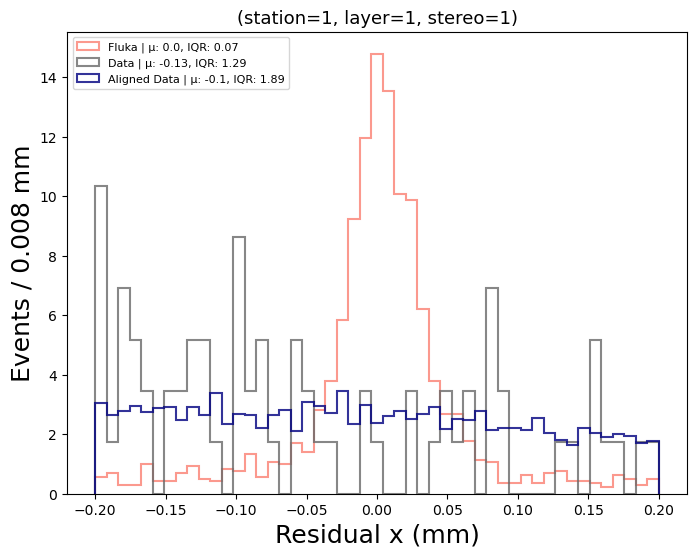

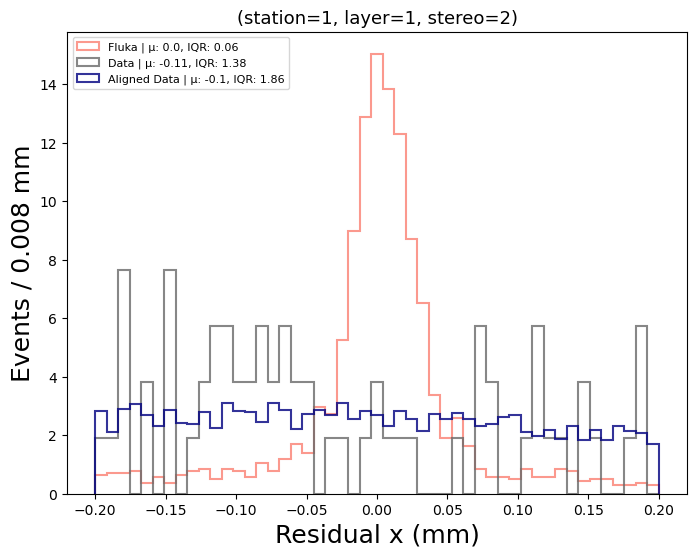

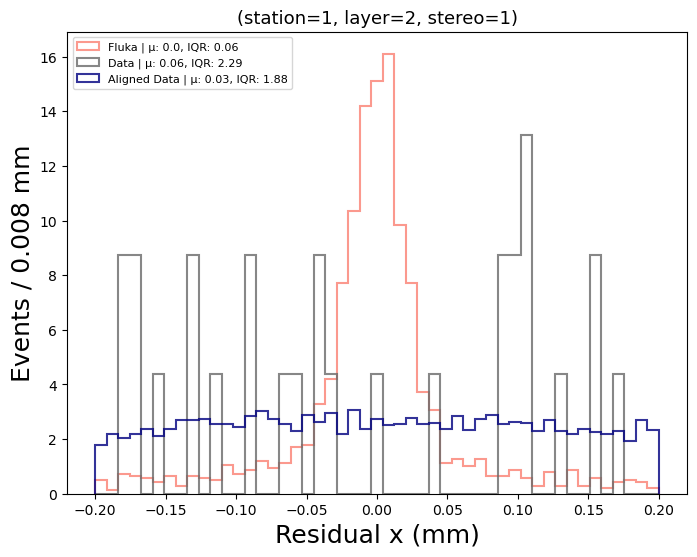

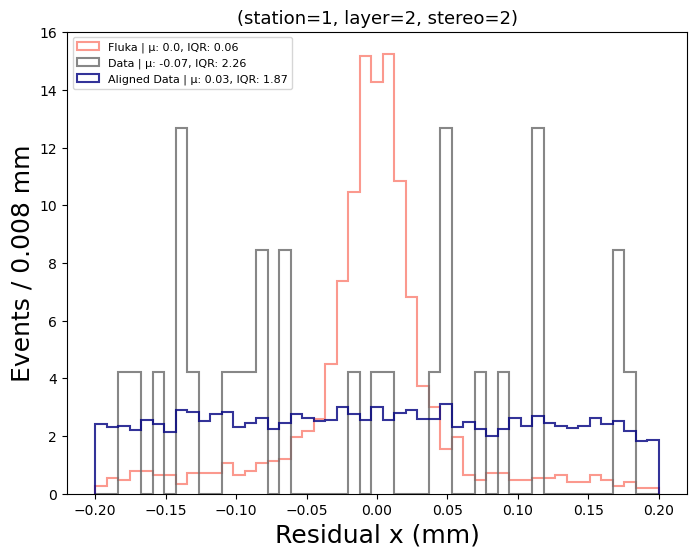

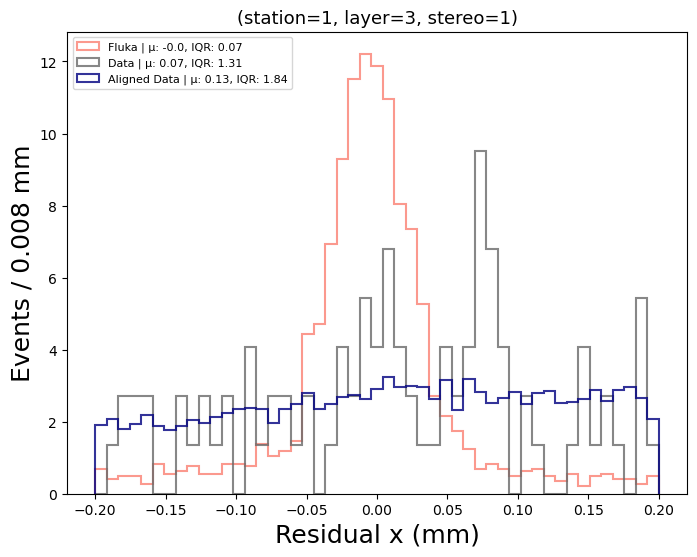

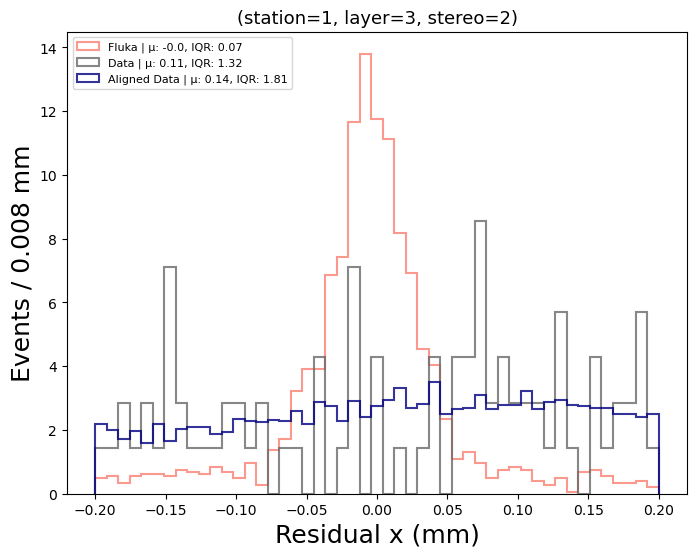

In [176]:
for i in range(1):
    for j in range(3):
        for l in range(2):
            fluka_med.append(np.median(res(fluka, i, j, l)))
            fluka_iqr.append(iqr(res(fluka, i, j, l)))
            col_med.append(np.median(res(collision, i, j, l)))
            col_iqr.append(iqr(res(collision, i, j, l)))
            plt.figure(figsize=(8, 6), dpi=100)
            plt.hist(res(fluka, i, j, l), color="salmon", histtype='step', linewidth=1.5, bins=np.linspace(-0.2, 0.2, 50), density=True, alpha=0.8, label=f'Fluka | µ: {round(np.median(res(fluka, i, j, l)), 2)}, IQR: {round(iqr(res(fluka, i, j, l)), 2)}')
            plt.hist(res(collision, i, j, l), color="dimgray", histtype='step', linewidth=1.5, bins=np.linspace(-0.2, 0.2, 50),  density=True,  alpha=0.8, label=f'Data | µ: {round(np.median(res(collision, i, j, l)), 2)}, IQR: {round(iqr(res(collision, i, j, l)), 2)}')
            plt.hist(res(ali_collision, i, j, l),color="navy", histtype='step', linewidth=1.5, bins=np.linspace(-0.2, 0.2, 50),  density=True,  alpha=0.8, label=f'Aligned Data | µ: {round(np.median(res(ali_collision, i, j, l)), 2)}, IQR: {round(iqr(res(ali_collision, i, j, l)), 2)}')
            plt.xlabel('Residual x (mm)', fontsize=18)
            plt.ylabel('Events / 0.008 mm', fontsize=18)
            # plt.xlim([-0.2, 0.2])
            plt.legend(fontsize=8, loc='upper left')
            plt.title(f'(station={i+1}, layer={j+1}, stereo={l+1})', fontsize=13)
            plt.show()
            

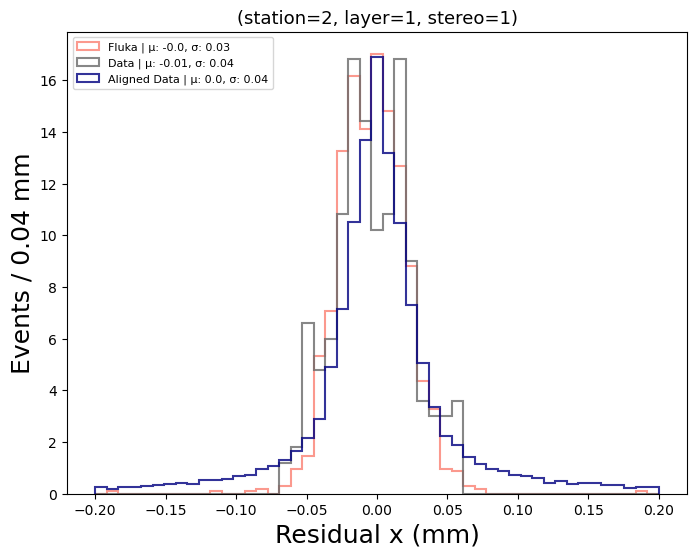

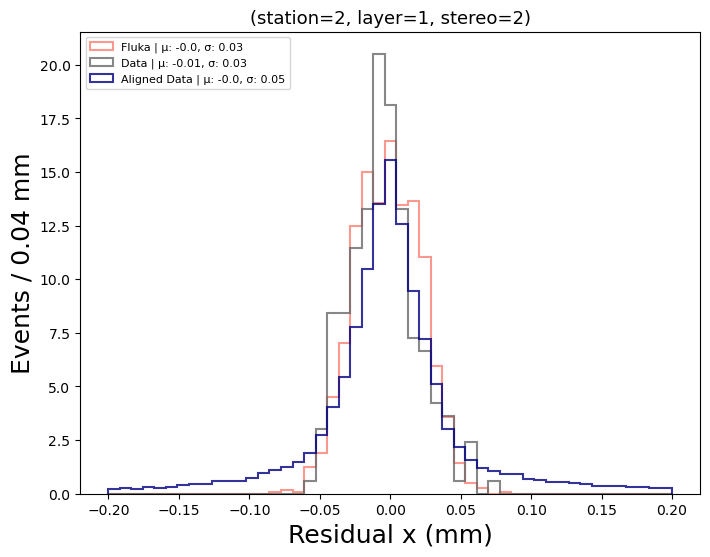

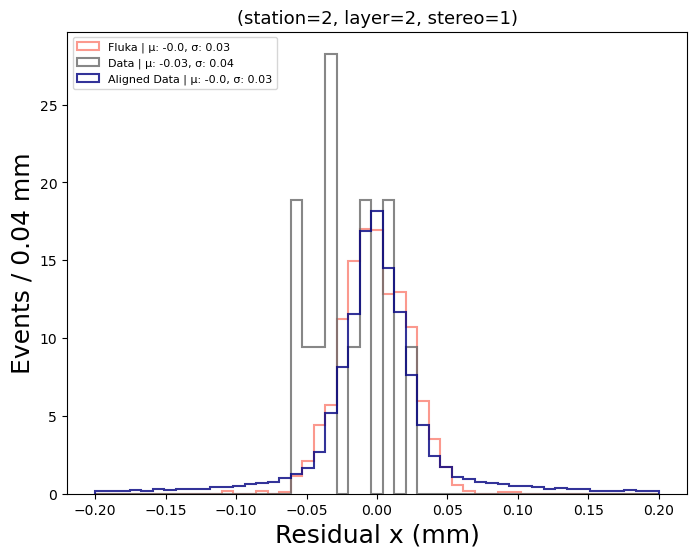

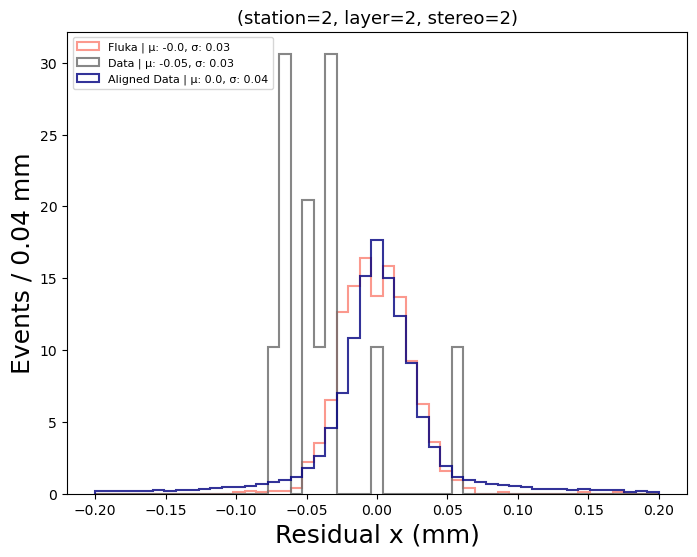

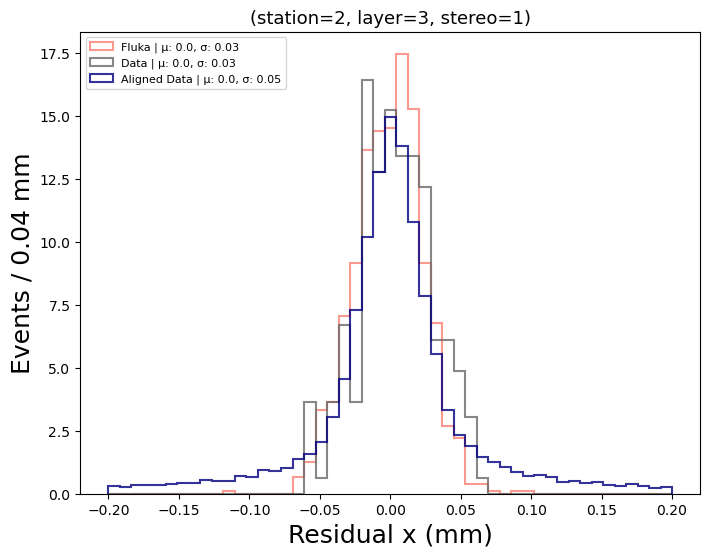

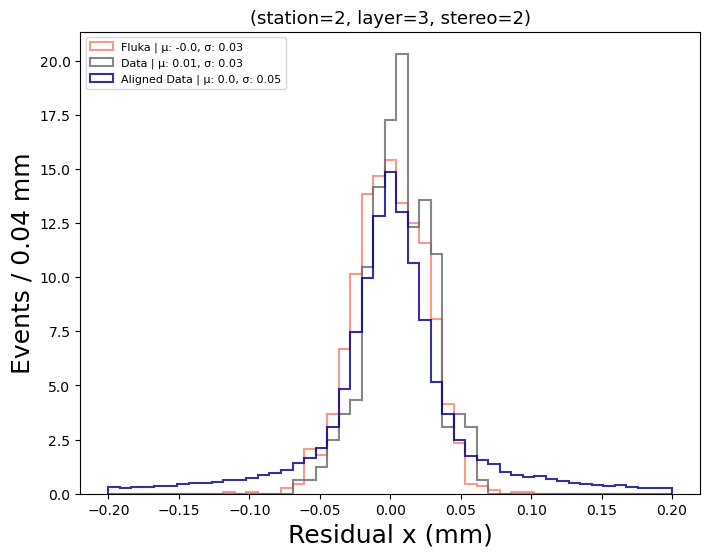

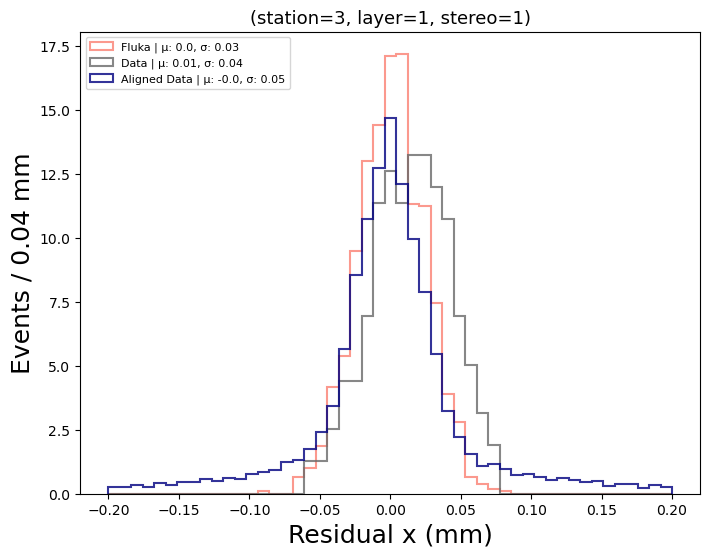

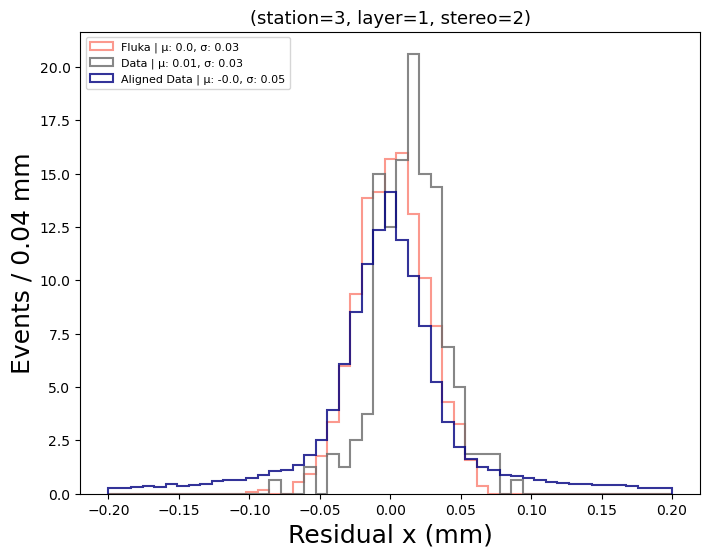

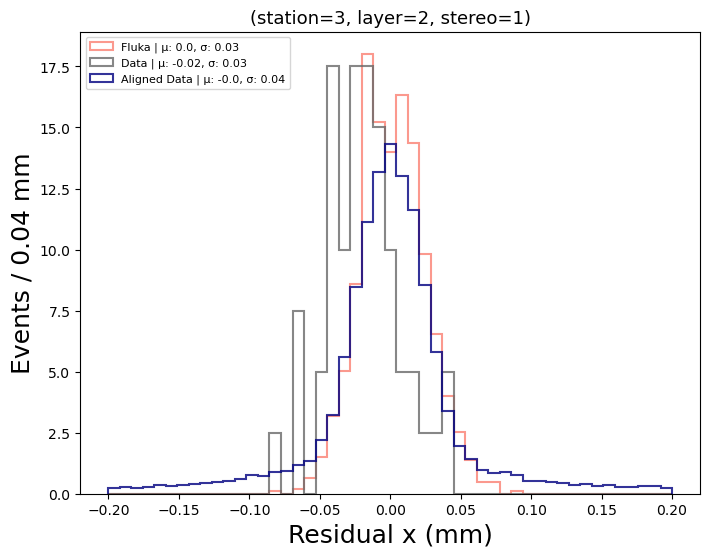

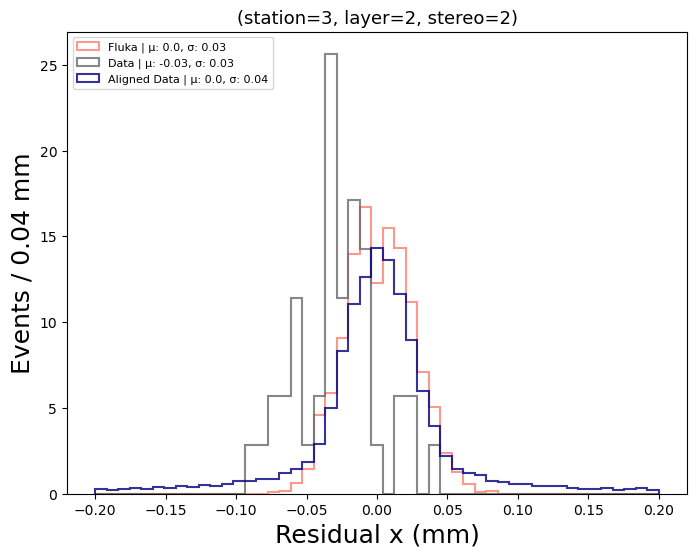

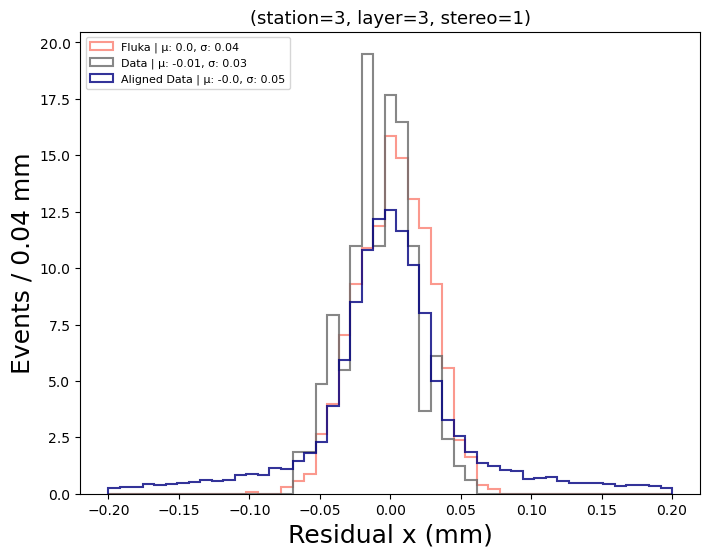

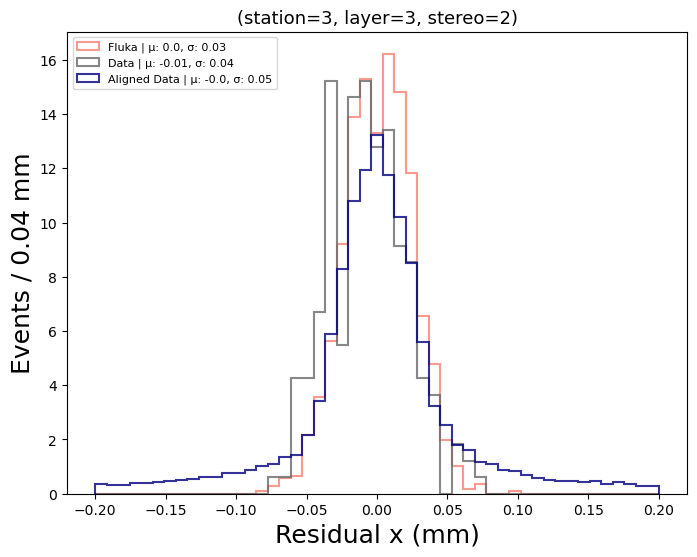

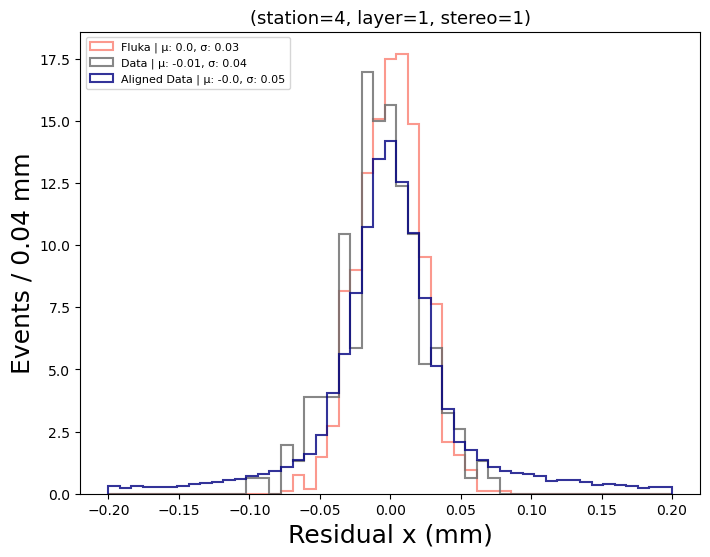

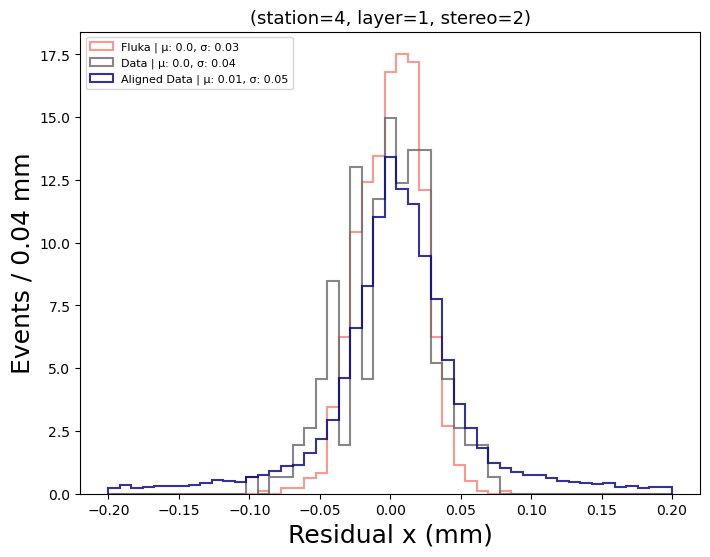

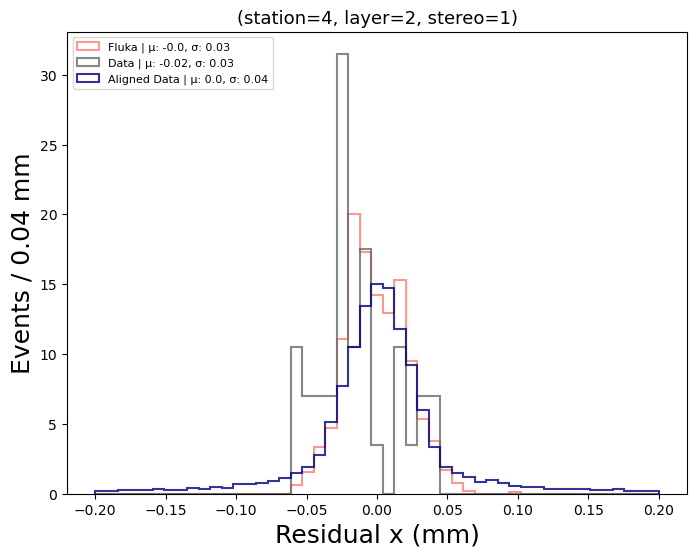

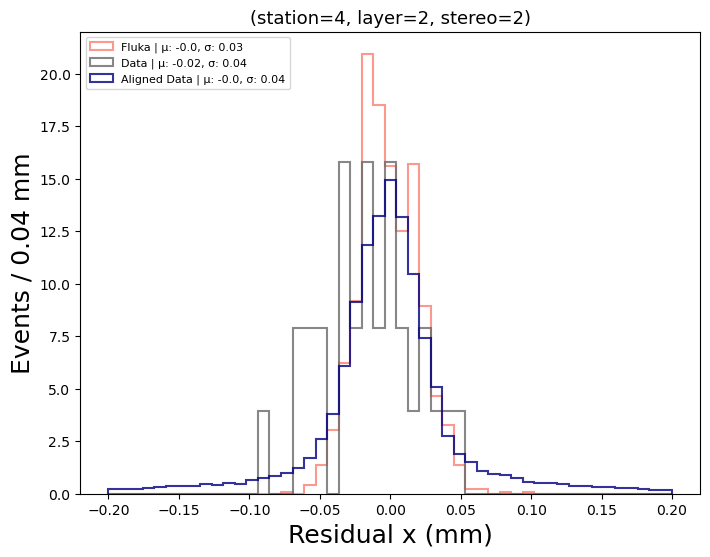

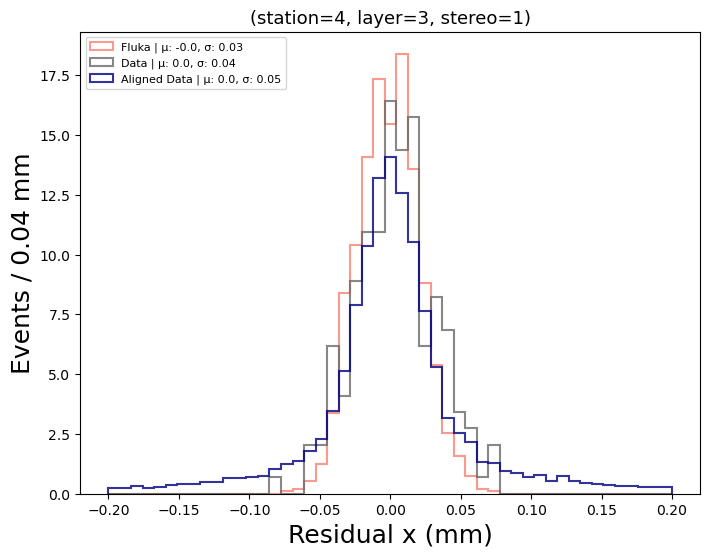

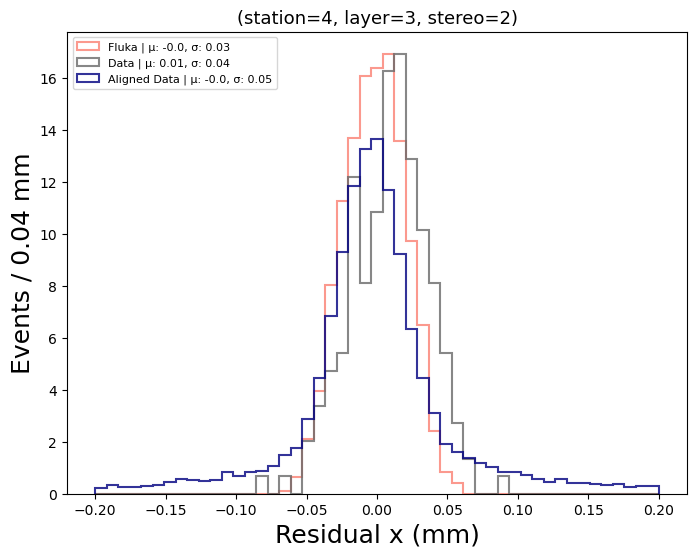

In [175]:
for i in range(1, 4):
    for j in range(3):
        for l in range(2):
            fluka_med.append(np.median(res(fluka, i, j, l)))
            fluka_iqr.append(iqr(res(fluka, i, j, l)))
            col_med.append(np.median(res(collision, i, j, l)))
            col_iqr.append(iqr(res(collision, i, j, l)))
            plt.figure(figsize=(8, 6), dpi=100)
            plt.hist(res(fluka, i, j, l), color="salmon", histtype='step', linewidth=1.5, bins=np.linspace(-0.2, 0.2, 50), density=True, alpha=0.8, label=f'Fluka | µ: {round(np.median(res(fluka, i, j, l)), 2)}, σ: {round(iqr(res(fluka, i, j, l)), 2)}')
            plt.hist(res(collision, i, j, l), color="dimgray", histtype='step', linewidth=1.5, bins=np.linspace(-0.2, 0.2, 50),  density=True,  alpha=0.8, label=f'Data | µ: {round(np.median(res(collision, i, j, l)), 2)}, σ: {round(iqr(res(collision, i, j, l)), 2)}')
            plt.hist(res(ali_collision, i, j, l),color="navy", histtype='step', linewidth=1.5, bins=np.linspace(-0.2, 0.2, 50),  density=True,  alpha=0.8, label=f'Aligned Data | µ: {round(np.median(res(ali_collision, i, j, l)), 2)}, σ: {round(iqr(res(ali_collision, i, j, l)), 2)}')
            plt.xlabel('Residual x (mm)', fontsize=18)
            plt.ylabel('Events / 0.008 mm', fontsize=18)
            # plt.xlim([-0.2, 0.2])
            plt.legend(fontsize=8, loc='upper left')
            plt.title(f'(station={i+1}, layer={j+1}, stereo={l+1})', fontsize=13)
            plt.show()
            